# NARMA10 task with Echo State Networks

This task consists in predicting the output of a 10-th order non-linear autoregressive moving average (NARMA) system.
- [Reference paper](https://doi.org/10.1016/j.neunet.2011.02.002)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools

from sklearn.metrics import mean_squared_error

The input of the system is a sequence of elements 𝑥(𝑡) randomly chosen according to a uniform distribution over [0, 0.5]. 

Given the input value 𝑥(𝑡), the task is to predict the corresponding value of 𝑦(𝑡).

- Import the dataset from the .csv file *NARMA10.csv*, where the first row represents the input and the second row represents the
target output. Different columns represent different time-steps.
- Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
    - For the sake of problem understanding, you can try to first visualize the timeseries data

In [2]:
dset = pd.read_csv('../data/NARMA10.csv', header=None).to_numpy()

x = dset[0]
y = dset[1]

trainX = x[:5000]
x_train = trainX[:4000]
x_val = trainX[4000:]

trainY = y[:5000] 
y_train = trainY[:4000]
y_val = trainY[4000:]

x_test = x[5000:]
y_test = y[5000:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((4000,), (4000,), (1000,), (1000,), (5000,), (5000,))

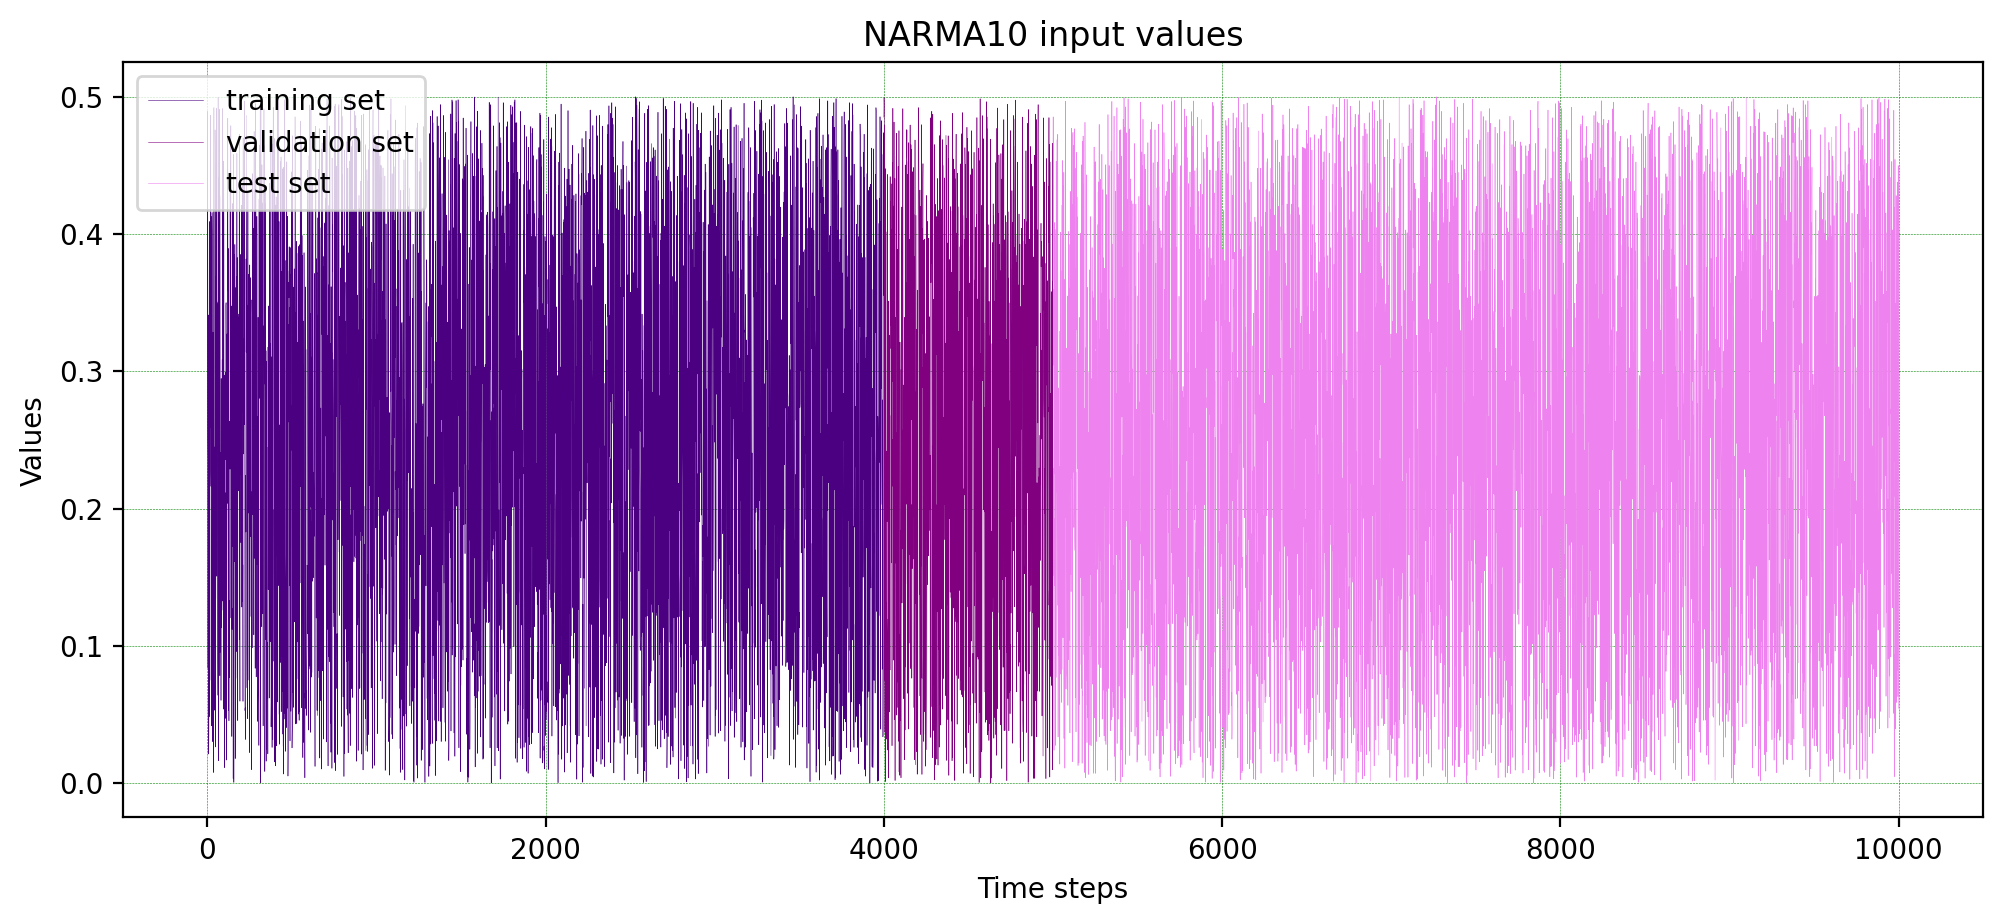

In [3]:
# plot_ts(x_train,x_val,x_test, "NARMA10 input values")

limit1=int(x_train.shape[0])
limit2=int(x_train.shape[0]+x_val.shape[0])
limit3=int(limit2+x_test.shape[0])

plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(0,limit1), x_train, color="indigo", linewidth=0.2, label="training set") 
plt.plot(range(limit1,limit2), x_val, color="purple", linewidth=0.2, label="validation set") 
plt.plot(range(limit2,limit3), x_test, color="violet", linewidth=0.2, label="test set") 

plt.title('NARMA10 input values')
plt.xlabel("Time steps")
plt.ylabel("Values")
plt.legend()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
#plt.savefig(str('plots/timeseries.jpeg'), edgecolor='black', dpi=400, transparent=True)
plt.show()

Implement from scratch the code required to initialize, run, train, and evaluate an **Echo State Network**. Your implementation should take into
consideration relevant hyper-parametrization of the neural network (e.g., number of reservoir neurons, spectral radius, etc.)

#### Grid search

In [4]:

###############################################################################
# # first test the nn then resume this complex grid
###############################################################################


class GS:
    
    def __init__(self, parameters:dict, Xset:tuple, Yset:tuple):
        self.Xset=Xset
        self.Yset=Yset
        param_grid = self.grid(self, parameters)
        min_loss, best_model = self.search(self, param_grid)
        self.min_loss = min_loss
        self.best_model = best_model # the best model discovered

    
    @staticmethod
    def grid(self, params):
        param_names=list(params.keys())
        param_values=list(params.values())
        param_combinations=list(itertools.product(*param_values))
        
        param_grid=[]
        for combination in param_combinations:
            param_grid.append(dict(zip(param_names, combination)))
        return param_grid 
        
        ###       !! FROM HERE ON, TO BE CHECKED BETTER AFTER DEVELOPING THE TRAINING FUNCION !!      ###
    @staticmethod
    def search(self, param_grid:tuple):
        predictions={}  
        for pg in param_grid:
            model=ESN(
                # input_dim=self.Xset.shape[1], 
                reservoir_dim=pg['reservoir'], 
                omega=pg['omega'], 
                sr=pg['sr'], 
                sparsity=pg['sparsity'], 
                leak=pg['leak'],
                transient=pg['tr'], 
                reg = pg['reg']
                )
            states_set = model.train(self.Xset.reshape(-1, 1), self.Yset)
            loss, y_pred = model.predict(self.Xset.reshape(-1, 1), self.Yset, states_set[-1])
            predictions[loss]=[pg, y_pred] 
        
        min_loss = min(predictions.keys())
        best_model = predictions[min_loss]
        
        return min_loss, best_model

## Echo State Network

In [5]:
'''
This code defines a class called `ESN` which stands for Echo State Network. 
An Echo State Network is a type of recurrent neural network known for its simplicity and effectiveness in time-series prediction tasks.
'''
class ESN:
    def __init__(self, reservoir_dim, omega, sr, sparsity, leak, transient, reg): 
        self.input_dim = 1
        self.reservoir_dim = reservoir_dim
        self.output_dim = 1
        self.omega = omega
        self.sr = sr
        self.sparsity = sparsity
        self.leak = leak
        self.transient=transient
        self.reg = reg

        # weight initialization
        ##W IN WITH SECOND DIMENSION AS INPUT_DIM IS A TEST
        self.W_in = (np.random.rand(self.reservoir_dim,self.input_dim) * 2 - 1) * self.omega #Choose the values of W from a random distribution scaled by a hyper-parameter ω_in
        
        self.W_res = np.random.rand(self.reservoir_dim, self.reservoir_dim) * 2 - 1 

        # apply sparsity
        mask = np.random.rand(self.reservoir_dim, self.reservoir_dim) > self.sparsity
        self.W_res[mask] = 0
        
        # spectral radius (ro) condition
        rho = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res *= sr / rho
        
        self.bias = (np.random.rand(self.reservoir_dim) * 2 - 1) * self.omega
        
        self.W_out = np.random.rand(self.reservoir_dim, self.output_dim) * 2 - 1
        # print(self.W_out.shape)
        
        
    def _update_state(self, state, input_vector):
        pre_activation = np.dot(self.W_in, input_vector) + np.dot(self.W_res, state) + self.bias
        return (1 - self.leak) * state + self.leak * np.tanh(pre_activation)
    
    
    def train(self, inputs, target):
        states = []#np.zeros((len(inputs), self.reservoir_dim))
        state = np.zeros(self.reservoir_dim)
        
        # Collecting states
        for t, u in enumerate(inputs):
            # u.shape, state.shape, states.shape
            state = self._update_state(state, u)
            states.append(state)
        
        states = np.array(states)
        
        # Discard the transient
        states, target = states[self.transient:], target[self.transient:]

        # Ridge regression (Tikhonov regularization)
        self.W_out = np.dot(np.dot(target.T, states), np.linalg.inv(np.dot(states.T, states) + self.reg * np.eye(states.shape[1]))).T
        # y_pred = np.dot(states, self.W_out)
        return states


        
    def predict(self, inputs,target,h0):
        states = []
        state = h0
        
        # Collecting states
        for t, u in enumerate(inputs):
            state = self._update_state(state, u)
            # states[t] = state
            states.append(state)
        
        states = np.array(states)

        y_pred = np.dot(states, self.W_out) #.T + self.bias_out 
        loss = mean_squared_error(target, y_pred)
        return loss, [y_pred, states[-1]]

In [6]:
params={
    'reservoir':[50, 100, 250],
    'omega':[0.1, 0.2, 0.5],
    'sr':[0.7, 0.8, 0.95],
    'sparsity':[0.5, 0.7, 0.9],
    'leak':[0.1, 0.5, 0.8],
    'tr':[100, 150],
    'reg':[1e-8, 1e-5]
}

grid_search=GS(params, x_train, y_train) 
best_loss, best_model=grid_search.min_loss, grid_search.best_model

config = best_model[0]
tr_predictions = best_model[1]
print(f'Training loss: {best_loss} configuration: {config}')


Training loss: 0.0003601441977947874 configuration: {'reservoir': 250, 'omega': 0.2, 'sr': 0.95, 'sparsity': 0.9, 'leak': 0.8, 'tr': 100, 'reg': 1e-08}


In [7]:
# Validate the ESN
model = ESN(config['reservoir'], config['omega'], config['sr'], config['sparsity'], config['leak'], config['tr'], config['reg'])
val_loss, val_predictions = model.predict(x_val.reshape(-1, 1), y_val, tr_predictions[-1])
print(f"Validation loss: {val_loss}")

Validation loss: 9.010164182735371


In [8]:

# Retrain on the full training set and test
# model = ESN(config['reservoir'], config['omega'], config['sr'], config['sparsity'], config['leak'])
states_set = model.train(np.concatenate([x_train, x_val]).reshape(-1, 1), np.concatenate([y_train, y_val]))
tr_loss, train_pred = model.predict(np.concatenate([x_train, x_val]).reshape(-1, 1), np.concatenate([y_train, y_val]), states_set[-1])
print(f"Training loss: {tr_loss}")

# model = ESN(config['reservoir'], config['omega'], config['sr'], config['sparsity'], config['leak'])
states_set = model.train(x_test.reshape(-1, 1), y_test)
ts_loss, test_pred = model.predict(x_test.reshape(-1, 1), y_test, states_set[-1])
print(f"Test loss: {ts_loss}")

Training loss: 0.0003921907152748178
Test loss: 0.0002947480652646072


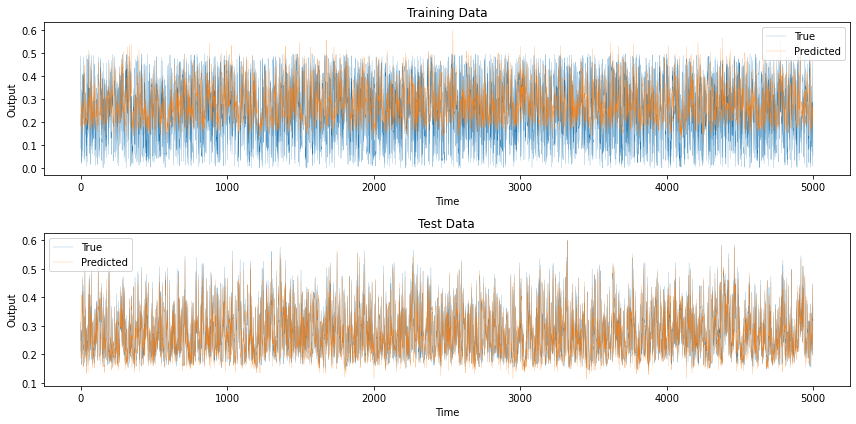

In [9]:
plt.figure(figsize=(12, 6))

# Plotting training data
plt.subplot(2, 1, 1)
plt.plot(np.concatenate([x_train, x_val]), label="True", linewidth=0.2)
plt.plot(train_pred[0], label="Predicted", linewidth=0.2) #[x for x in np.asarray(train_pred, dtype='object')]
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()

# Plotting testing data
plt.subplot(2, 1, 2)
plt.plot(y_test, label="True", linewidth=0.2)
plt.plot(test_pred[0], label="Predicted", linewidth=0.2) #[x for x in np.asarray(test_pred, dtype='object')]
plt.title('Test Data')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.savefig('plots/ESN_narma10_results.jpeg', edgecolor='black', dpi=400, transparent=True)
plt.show()

# Example usage:
# Assuming y_train, train_pred, y_test, and test_pred are defined:
# plot_final_results(y_train, train_pred, y_test, test_pred)
